# (A) Dependencies

In [7]:
import os
import pickle
import numpy as np
import matplotlib.pyplot as plt

from pathlib import Path
from collections import Counter

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

# (B) Dataset

### Downloading the dataset via kaggle api
- [CAPTCHA Images Kaggle  Dataset](https://www.kaggle.com/datasets/fournierp/captcha-version-2-images)

In [8]:
# Download kaggle api
!pip install -q kaggle

In [9]:
# Creat the convenient dir for token. (The system will seach this dir)
! mkdir ~/.kaggle

- Upload your kaggle token
- For creating a token
  - Sign in your Kaggle account,
  - Open Account section from  your icon menu
  - Scroll to API section
  -  Click on __Create New API Token__
     - It will download kaggle.json file on your machine. 
  - Upload this kaggle.json file into your working directory on your google colab session.
  - Run floowing codes

In [10]:
# upload your kaggle token to download dataset.
from google.colab import files
files.upload();

Saving kaggle.json to kaggle.json


In [11]:
# Copy the json file into correct path, then remove the firt one it
! cp kaggle.json ~/.kaggle/
! rm -f kaggle.json

In [12]:
# Set the token can't readable for other user if you save it somewhere
! chmod 600 ~/.kaggle/kaggle.json

In [13]:
# Download your data "Competition-name"
#! kaggle competitions download -c 'competition-name'
!kaggle datasets download -d fournierp/captcha-version-2-images

 98% 17.0M/17.4M [00:01<00:00, 20.9MB/s]
100% 17.4M/17.4M [00:01<00:00, 12.5MB/s]


In [14]:
!unzip 'captcha-version-2-images.zip';

Archive:  captcha-version-2-images.zip
  inflating: samples/226md.png       
  inflating: samples/22d5n.png       
  inflating: samples/2356g.png       
  inflating: samples/23mdg.png       
  inflating: samples/23n88.png       
  inflating: samples/243mm.png       
  inflating: samples/244e2.png       
  inflating: samples/245y5.png       
  inflating: samples/24f6w.png       
  inflating: samples/24pew.png       
  inflating: samples/25257.png       
  inflating: samples/253dc.png       
  inflating: samples/25egp.png       
  inflating: samples/25m6p.png       
  inflating: samples/25p2m.png       
  inflating: samples/25w53.png       
  inflating: samples/264m5.png       
  inflating: samples/268g2.png       
  inflating: samples/28348.png       
  inflating: samples/28x47.png       
  inflating: samples/2b827.png       
  inflating: samples/2bg48.png       
  inflating: samples/2cegf.png       
  inflating: samples/2cg58.png       
  inflating: samples/2cgyx.png       
  inflating

## Loading the dataset

In [15]:
# Path to the data directory
data_dir = Path("./samples/")

In [16]:
# Get list of all the images
images = sorted(list(map(str, list(data_dir.glob("*.png")))))
labels = [img.split(os.path.sep)[-1].split(".png")[0] for img in images]
characters = set(char for label in labels for char in label)
characters = sorted(list(characters))

print("Image size: ", len(images))
print("Label Sİze: ", len(labels))
print("unique characters: ", len(characters))
print("Characters present: ", characters)

Image size:  1040
Label Sİze:  1040
unique characters:  19
Characters present:  ['2', '3', '4', '5', '6', '7', '8', 'b', 'c', 'd', 'e', 'f', 'g', 'm', 'n', 'p', 'w', 'x', 'y']


In [17]:
# Configurations
AUTOTUNE = tf.data.AUTOTUNE

# Batch size for training and validation
batch_size = 16

# Desired image dimensions
img_width = 200
img_height = 50

downsample_factor = 4

# Maximum length of any captcha in the dataset
max_length = max([len(label) for label in labels])
max_length

5

# (C) Pre-processing

## Utils Functions

In [18]:
def split_data(images, labels, train_size=0.9, shuffle=True):
    # 1. Get the total size of the dataset
    size = len(images)
    
    # 2. Make an indices array and shuffle it, if required
    indices = np.arange(size)
    if shuffle:
        np.random.shuffle(indices)
    
    # 3. Get the size of training samples
    train_samples = int(size * train_size)
    
    # 4. Split data into training and validation sets
    x_train, y_train = images[indices[:train_samples]], labels[indices[:train_samples]]
    x_valid, y_valid = images[indices[train_samples:]], labels[indices[train_samples:]]
    
    return x_train, x_valid, y_train, y_valid


def encode_single_sample(img_path, label):
    
    # 1. Read image
    img = tf.io.read_file(img_path)
    
    # 2. Decode and convert to grayscale
    img = tf.io.decode_png(img, channels=1)
    
    # 3. Convert to float32 in [0, 1] range
    img = tf.image.convert_image_dtype(img, tf.float32)
    
    # 4. Resize to the desired size
    img = tf.image.resize(img, [img_height, img_width])
    
    # 5. Transpose the image because we want the time
    # dimension to correspond to the width of the image.
    img = tf.transpose(img, perm=[1, 0, 2])
    
    # 6. Map the characters in label to numbers
    label = char_to_num(tf.strings.unicode_split(label, input_encoding="UTF-8"))
    
    # 7. Return a dict as our model is expecting two inputs
    return {"image": img, "label": label}


## Implementation 

In [19]:
# Splitting data into training and validation sets
x_train, x_valid, y_train, y_valid = split_data(np.array(images), np.array(labels))

In [20]:
# Mapping characters to integers
char_to_num = layers.StringLookup(
    vocabulary=list(characters), mask_token=None
)

# Mapping integers back to original characters
num_to_char = layers.StringLookup(
    vocabulary=char_to_num.get_vocabulary(), mask_token=None, invert=True
)

In [21]:
import pickle
pickle.dump(list(characters), open("char_to_num", 'wb'))
pickle.dump(char_to_num.get_vocabulary(), open("num_to_char", 'wb'))

In [22]:
from google.colab import files
files.download("char_to_num")
files.download("num_to_char")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

## Create `Dataset` objects

In [15]:
# Creating the dataset objects
train_dataset = tf.data.Dataset.from_tensor_slices((x_train, y_train))
validation_dataset = tf.data.Dataset.from_tensor_slices((x_valid, y_valid))

In [16]:
# Implementing the pre-process 
train_dataset = train_dataset.map(encode_single_sample, num_parallel_calls=AUTOTUNE)
validation_dataset = validation_dataset.map(encode_single_sample, num_parallel_calls=AUTOTUNE)

In [17]:
# Batching the dataset
train_dataset = train_dataset.batch(batch_size)
validation_dataset = validation_dataset.batch(batch_size)

In [18]:
# Performance Configuration
train_dataset = train_dataset.prefetch(buffer_size=AUTOTUNE)
validation_dataset = validation_dataset.prefetch(buffer_size=AUTOTUNE)

## Visualize the data

In [19]:
def display_data(dataset, sample_size, cs=4, rs=4):
  for batch in dataset.take(sample_size):
    
    # unpacking the data
    images = batch["image"]
    labels = batch["label"]

    for i in range(batch_size):

        # Adjusting the forms into valid form
        img = (images[i] * 255).numpy().astype("uint8")
        label = tf.strings.reduce_join(num_to_char(labels[i])).numpy().decode("utf-8")
        
        # displaying the data
        plt.subplot(rs, cs, i+1)
        
        plt.imshow(img[:, :, 0].T, cmap="gray")
        plt.title(label)
        plt.axis("off")

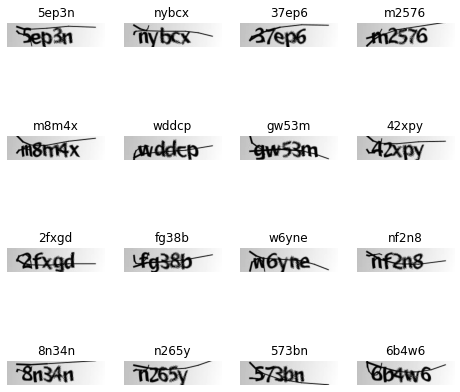

In [20]:
cs, rs = 4, batch_size//4 + 1 
sample_batch_size = 1

plt.figure(figsize=(cs*2, rs*2))
display_data(train_dataset, sample_batch_size, cs, rs)

# (D) Modelling

## Architecture

In [33]:
class CTCLayer(layers.Layer):
    def __init__(self, name=None):
        super().__init__(name=name)
        self.loss_fn = keras.backend.ctc_batch_cost

    def call(self, y_true, y_pred):
        #casting the type to become valid form
        batch_len = tf.cast(tf.shape(y_true)[0], dtype="int64")
        input_length = tf.cast(tf.shape(y_pred)[1], dtype="int64")
        label_length = tf.cast(tf.shape(y_true)[1], dtype="int64")

        # adjusting the shape 
        input_length = input_length * tf.ones(shape=(batch_len, 1), dtype="int64")
        label_length = label_length * tf.ones(shape=(batch_len, 1), dtype="int64")

        # calculating the loss 
        loss = self.loss_fn(y_true, y_pred, input_length, label_length)
        self.add_loss(loss)

        return y_pred

In [34]:
def build_model(img_width=img_width, img_height=img_height):
    
    # preparing  the params
    img_shape = (img_width, img_height, 1)
    conv_params = {
        "activation":"relu",
        "kernel_initializer":"he_normal",
        "padding":"same",
    }
    
    # Inputs to the model
    input_img = layers.Input(shape=img_shape, name="image", dtype="float32")
    labels = layers.Input(name="label", shape=(None,), dtype="float32")

    # Block-1: First conv block
    x = layers.Conv2D(32, (3, 3), name="Conv1", **conv_params)(input_img)
    x = layers.MaxPooling2D((2, 2), name="pool1")(x)

    # Block-2: Second conv block
    x = layers.Conv2D(64,(3, 3), name="Conv2",**conv_params)(x)
    x = layers.MaxPooling2D((2, 2), name="pool2")(x)

    # layer-3: 2x maxpooling with 2 stride. Img smalled 4 times.
    new_shape = ((img_width // 4), (img_height // 4) * 64)
    x = layers.Reshape(target_shape=new_shape, name="reshape")(x)
    x = layers.Dense(64, activation="relu", name="dense1")(x)
    x = layers.Dropout(0.2)(x)

    # Block-4: RNNs
    x = layers.Bidirectional(layers.LSTM(128, return_sequences=True, dropout=0.25))(x)
    x = layers.Bidirectional(layers.LSTM(64, return_sequences=True, dropout=0.25))(x)

    # Block-5: Output layer of image data
    voc_size = len(char_to_num.get_vocabulary()) + 1
    x = layers.Dense(voc_size, activation="softmax", name="dense2")(x)

    # Add CTC layer for calculating CTC loss at each step
    output = CTCLayer(name="ctc_loss")(labels, x)

    # Define the model
    model = keras.models.Model(inputs=[input_img, labels], outputs=output, name="ocr_model")

    return model


In [35]:
# Get the model
model = build_model()
model.compile(optimizer=keras.optimizers.Adam())

In [36]:
model.summary()

Model: "ocr_model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 image (InputLayer)             [(None, 200, 50, 1)  0           []                               
                                ]                                                                 
                                                                                                  
 Conv1 (Conv2D)                 (None, 200, 50, 32)  320         ['image[0][0]']                  
                                                                                                  
 pool1 (MaxPooling2D)           (None, 100, 25, 32)  0           ['Conv1[0][0]']                  
                                                                                                  
 Conv2 (Conv2D)                 (None, 100, 25, 64)  18496       ['pool1[0][0]']          

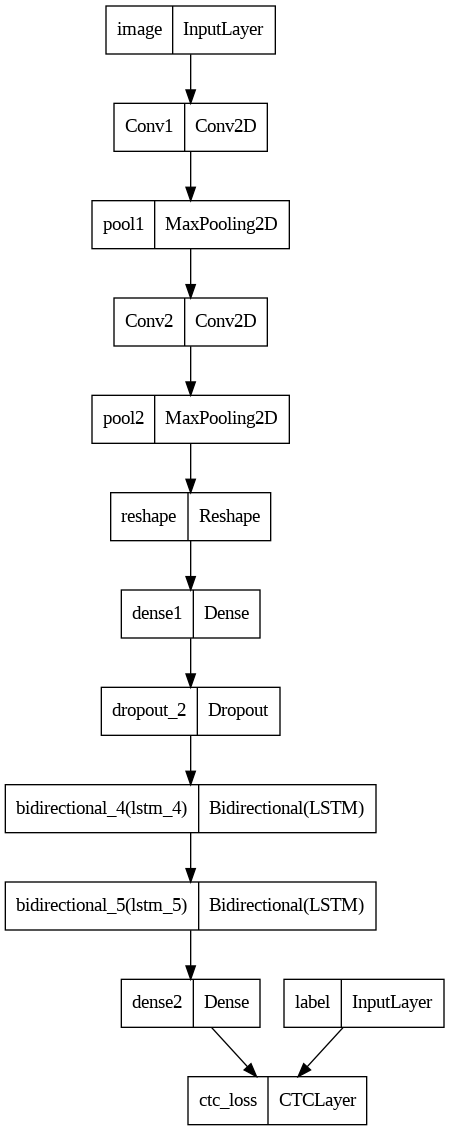

In [37]:
tf.keras.utils.plot_model(model)

## Training

In [41]:
from tensorflow.keras.callbacks import EarlyStopping
epochs = 100
early_stopping_params = {
    "monitor":"val_loss",
    "patience":10,
    "restore_best_weights":True
}

# Add early stopping
callbacks = [
    EarlyStopping(**early_stopping_params),
]

In [42]:
# Train the model
history = model.fit(
    train_dataset,
    validation_data=validation_dataset,
    epochs=epochs,
    callbacks=callbacks,
)

Epoch 1/100
59/59 [==============================] - 23s 79ms/step - loss: 19.9705 - val_loss: 16.4609
Epoch 2/100
59/59 [==============================] - 2s 32ms/step - loss: 16.3813 - val_loss: 16.4366
Epoch 3/100
59/59 [==============================] - 2s 33ms/step - loss: 16.3671 - val_loss: 16.4294
Epoch 4/100
59/59 [==============================] - 2s 31ms/step - loss: 16.3525 - val_loss: 16.4316
Epoch 5/100
59/59 [==============================] - 3s 44ms/step - loss: 16.3440 - val_loss: 16.4123
Epoch 6/100
59/59 [==============================] - 2s 33ms/step - loss: 16.3300 - val_loss: 16.3896
Epoch 7/100
59/59 [==============================] - 2s 32ms/step - loss: 16.2637 - val_loss: 16.2068
Epoch 8/100
59/59 [==============================] - 2s 32ms/step - loss: 15.8714 - val_loss: 15.4937
Epoch 9/100
59/59 [==============================] - 2s 41ms/step - loss: 14.1721 - val_loss: 11.8572
Epoch 10/100
59/59 [==============================] - 2s 42ms/step - loss: 9.3947

In [43]:
history.history.keys()

dict_keys(['loss', 'val_loss'])

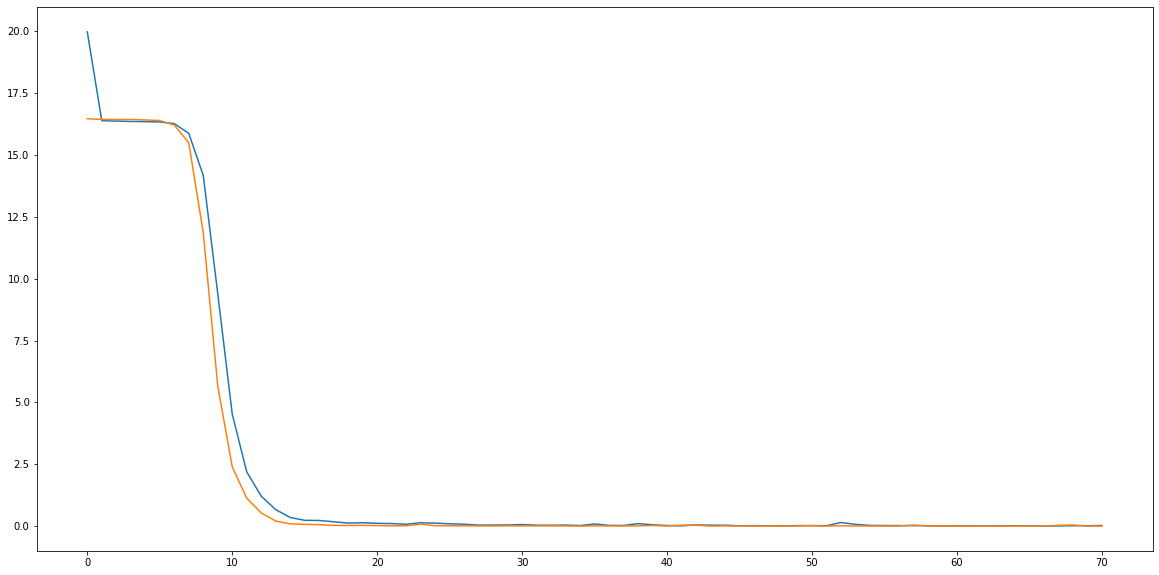

In [44]:
plt.figure(figsize=(20,10))

plt.plot(history.history["loss"], label="loss")
plt.plot(history.history["val_loss"], label="val_loss")

## Prediction

In [46]:
# Get the prediction model by extracting layers till the output layer
prediction_model = keras.models.Model(
    model.get_layer(name="image").input,
    model.get_layer(name="dense2").output,
    name="ocr_model"
)
prediction_model.summary()

Model: "ocr_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 image (InputLayer)          [(None, 200, 50, 1)]      0         
                                                                 
 Conv1 (Conv2D)              (None, 200, 50, 32)       320       
                                                                 
 pool1 (MaxPooling2D)        (None, 100, 25, 32)       0         
                                                                 
 Conv2 (Conv2D)              (None, 100, 25, 64)       18496     
                                                                 
 pool2 (MaxPooling2D)        (None, 50, 12, 64)        0         
                                                                 
 reshape (Reshape)           (None, 50, 768)           0         
                                                                 
 dense1 (Dense)              (None, 50, 64)            49

In [47]:
# A utility function to decode the output of the network
def decode_batch_predictions(pred):

    # creating convenient data
    input_len = np.ones(pred.shape[0]) * pred.shape[1]
    
    # Use greedy search. For complex tasks, you can use beam search
    results_all = keras.backend.ctc_decode(pred, input_length=input_len, greedy=True)
    results = results_all[0][0][:, :max_length]
    
    # converting the results into text format
    output_text = [
        tf.strings.reduce_join(num_to_char(res)).numpy().decode("utf-8") 
        for res in results
    ]

    return output_text

1/1 [==============================] - 0s 38ms/step


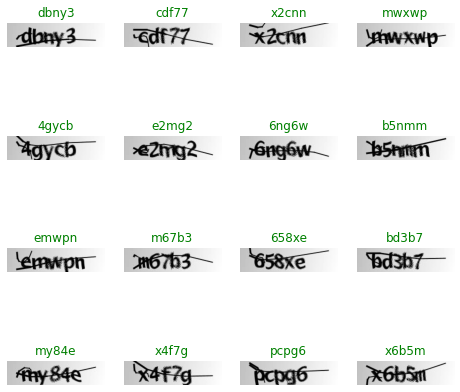

In [49]:
#  Let's check results on some validation samples
for batch in validation_dataset.take(1):
    
    # extracting the current data
    batch_images = batch["image"]
    batch_labels = batch["label"]

    # prediction
    preds = prediction_model.predict(batch_images)
    
    # decoding the predictions (y pred)
    pred_texts = decode_batch_predictions(preds)

    # extracting the actual y
    orig_texts = [
        tf.strings.reduce_join(num_to_char(label)).numpy().decode("utf-8")
        for label in batch_labels
    ]

    # visualizating the predictions
    cs, rs = 4, len(pred_texts)//4+1
    plt.figure(figsize=(cs*2, rs*2))

    for i in range(len(pred_texts)):

        # adjusting the into convenient form
        img = ((batch_images[i, :, :, 0] * 255).numpy().astype(np.uint8)).T
        col = 'r' if pred_texts[i] != orig_texts[i] else 'g'
        title = f'{pred_texts[i]}'

        plt.subplot(rs,cs, i+1)
        plt.imshow(img, cmap="gray")
        plt.title(title, color = col)
        plt.axis("off")
plt.show()

# (E) Saving the model

## Model

In [50]:
save_path = f"{prediction_model.name}"
prediction_model.save(save_path)

In [51]:
import os
os.system(f"zip -r {save_path}.zip {save_path}");

In [52]:
from google.colab import files
files.download(f"{save_path}.zip")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

## Example Data

In [53]:
from glob import glob

# Finding out examples
ex_imgs_paths = np.array(glob(f"samples/samples/*.png"))

# random selection
random_selected_img_paths = np.random.choice(ex_imgs_paths, 10)

In [54]:
# creating new dir, and copying the random examles into there
examples = "Examples"
if not os.path.exists(examples): os.mkdir(examples)

for path in random_selected_img_paths:
  src, dst = path, os.path.join(examples, os.path.basename(path))
  print(f"{src:<30} {dst}")
  os.system(f"cp -r {src} {dst}")

samples/samples/4433m.png      Examples/4433m.png
samples/samples/ennmm.png      Examples/ennmm.png
samples/samples/6bnnm.png      Examples/6bnnm.png
samples/samples/3bx86.png      Examples/3bx86.png
samples/samples/bw5nf.png      Examples/bw5nf.png
samples/samples/3cpwb.png      Examples/3cpwb.png
samples/samples/3xcgg.png      Examples/3xcgg.png
samples/samples/3nnpw.png      Examples/3nnpw.png
samples/samples/478nx.png      Examples/478nx.png
samples/samples/5n3w4.png      Examples/5n3w4.png


In [55]:
# zipping the examples
os.system(f"zip -r {examples}.zip {examples}");

In [56]:
# downloading the example images
from google.colab import files
files.download(f"{examples}.zip")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

# (F) Deployment

In [1]:
import os
import pickle
import numpy as np
import tensorflow as tf
from tensorflow.keras.layers import StringLookup

if os.system("pip freeze | grep gradio==") != 0: os.system("pip install gradio")
import gradio as gr

In [2]:
!unzip ocr_model.zip
!unzip Examples.zip

Archive:  ocr_model.zip
   creating: ocr_model/
 extracting: ocr_model/fingerprint.pb  
   creating: ocr_model/assets/
   creating: ocr_model/variables/
  inflating: ocr_model/variables/variables.index  
  inflating: ocr_model/variables/variables.data-00000-of-00001  
  inflating: ocr_model/saved_model.pb  
  inflating: ocr_model/keras_metadata.pb  
Archive:  Examples.zip
   creating: Examples/
 extracting: Examples/478nx.png      
 extracting: Examples/3nnpw.png      
 extracting: Examples/3xcgg.png      
 extracting: Examples/3bx86.png      
 extracting: Examples/bw5nf.png      
 extracting: Examples/5n3w4.png      
 extracting: Examples/ennmm.png      
  inflating: Examples/3cpwb.png      
  inflating: Examples/6bnnm.png      
 extracting: Examples/4433m.png      


In [3]:
max_length = 5
model_path = "ocr_model"

In [4]:
ocr_model = tf.keras.models.load_model(model_path)

char_to_num_voc = pickle.load(open("char_to_num", 'rb'))
num_to_char_voc = pickle.load(open("num_to_char", 'rb'))

char_to_num = StringLookup(vocabulary=char_to_num_voc, mask_token=None)
num_to_char = StringLookup(vocabulary=num_to_char_voc, mask_token=None, invert=True)

In [5]:
def encode_img(image_path, img_height=50, img_width=200):
    
    # Load the image file using a file I/O operation
    img = tf.io.read_file(image_path)

    # Decode the image file as a tensor using tf.image.decode_image()
    img = tf.image.decode_image(img, channels=1)

    # Convert the image tensor to float32 data type and rescale the pixel values to the range [0, 1]
    img = tf.image.convert_image_dtype(img, tf.float32)
    
    # 4. Resize to the desired size
    img = tf.image.resize(img, [img_height, img_width])
    
    # 5. Transpose the image because we want the time
    # dimension to correspond to the width of the image.
    img = tf.transpose(img, perm=[1, 0, 2])
    
    return img

def decode_batch_predictions(pred):

    # creating convenient data
    input_len = np.ones(pred.shape[0]) * pred.shape[1]
    
    # Use greedy search. For complex tasks, you can use beam search
    decode_params = {"y_pred":pred, "input_length":input_len, "greedy":True}
    results_all = tf.keras.backend.ctc_decode(**decode_params)
    results = results_all[0][0][:, :max_length]
    
    # converting the results into text format
    output_text = [
        tf.strings.reduce_join(num_to_char(res)).numpy().decode("utf-8") 
        for res in results
    ]

    return output_text[0]

In [6]:
def extract_text(image_path):

  # loading the image
  img = encode_img(image_path)

  # Adjusting the sahpe to predict
  batch_image = tf.expand_dims(img, 0)

  # prediction
  pred = ocr_model.predict(batch_image)
  
  # decoding the predictions (y pred)
  pred_text = decode_batch_predictions(pred)
  
  return pred_text

In [7]:
extract_text("Examples/3bx86.png")

1/1 [==============================] - 3s 3s/step


'3bx86'

In [8]:
import gradio as gr

with gr.Blocks() as demo:
    
    # creating the components
    img_path = gr.Image(type="filepath", source="upload")
    extract_btn = gr.Button("Extract text form image")
    output = gr.Textbox()

    # connecting the button functions
    extract_btn.click(extract_text, inputs=img_path, outputs=output)

    # setting the exmples
    gr.Examples("Examples", img_path)

In [9]:
demo.launch()

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
Note: opening Chrome Inspector may crash demo inside Colab notebooks.

To create a public link, set `share=True` in `launch()`.


<IPython.core.display.Javascript object>